In [60]:
import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from cobra.io import read_sbml_model


model = read_sbml_model("../model/Rpom_05.xml")

https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http

In [62]:
# Using biocyc pipeline template file, load all reactions from both databases
template = pd.read_excel("../model_building/biocyc_update_pipeline/templates/template.xlsx", sheet_name="New reactions")
template

,Reaction ID,Reaction name 1,Reaction name 2,In DB1?,In DB2?,Gene-reaction rule 1,Gene-reaction rule 2,Stoichiometry 1,Stoichiometry 2,Bounds 1,Bounds 2,Metabolites not in Model,Metabolites without data,Has-Class-Metabolites,Polymerization,Is-Class,Has-Subclasses,Has-Instances,Issues,Recommendation
0,TR-20,TonB Dependent Transport,TonB Dependent Transport,True,True,(),(),{},{},"(0, 1000)","(0, 1000)",[],[],False,False,True,False,False,['No stoichiometry data'],Do not add
1,RXN-22711,NaN,NaN,False,True,NaN,(),NaN,"{'CHORISMATE[c]': -1, 'AMMONIA[c]': -1, 'PROTO...",NaN,"(0, 1000)",['CPD-9517[c]'],[],False,False,False,False,False,['Reaction has metabolites missing from the mo...,Add
2,RXN-16540,NaN,NaN,True,False,(SPOA0288),NaN,"{'PALMITYL-COA[c]': -1, 'ETF-Oxidized[c]': -1,...",NaN,"(0, 1000)",NaN,[],[],True,False,False,False,False,"['Reaction has class metabolites, may require ...",Manual review
3,2.7.8.24-RXN,NaN,NaN,True,False,(SPO3131),NaN,"{'CHOLINE[c]': -1, 'CDPDIACYLGLYCEROL[c]': -1,...",NaN,"(0, 1000)",NaN,['PHOSPHATIDYLCHOLINE[c]'],[],True,False,False,False,False,['Reaction has metabolites missing from the mo...,Manual review
4,RXN-22482,NaN,NaN,False,True,NaN,(SPO_RS09800),NaN,"{'OH-ACYL-ACP[c]': -1, 'UDP-3R-hydroxyacyl-Glc...",NaN,"(0, 1000)","['OH-ACYL-ACP[c]', 'UDP-3R-hydroxyacyl-GlcN[c]...",[],True,False,False,False,False,['Reaction has metabolites missing from the mo...,Manual review
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1348,2.1.1.77-RXN,NaN,NaN,True,True,(SPO1239 or SPO2687),(SPO_RS06310 or SPO_RS13630),"{'S-ADENOSYLMETHIONINE[c]': -1, 'PROTEIN-L-BET...","{'S-ADENOSYLMETHIONINE[c]': -1, 'PROTEIN-L-BET...","(0, 1000)","(0, 1000)","['PROTEIN-L-BETA-ISOASPARTATES[c]', 'PROTEIN-L...",[],True,False,False,False,False,['Reaction has metabolites missing from the mo...,Manual review
1349,RXN0-5242,NaN,NaN,True,False,(),NaN,"{'NITRATE[c]': -1, 'PROTON[c]': -2, 'e<SUP>-</...",NaN,"(0, 1000)",NaN,['e<SUP>-</SUP>[c]'],['e<SUP>-</SUP>[c]'],False,False,False,False,False,['Reaction has metabolites missing from the mo...,Do not add
1350,RXN-15714,NaN,5-aminolevulinyl-CoA synthase,False,True,NaN,(SPO_RS10495 or SPO_RS12880),NaN,"{'5-AMINO-LEVULINATE[c]': -1, 'CO-A[c]': -1, '...",NaN,NaN,['CPD-16937[c]'],[],False,False,False,False,False,['Reaction has metabolites missing from the mo...,Add
1351,RXN-14805,NaN,NaN,True,False,(G1RHL-2403 or G1RHL-560),NaN,"{'CPD-12777[c]': -1, 'T2-DECENOYL-COA[c]': 1, ...",NaN,NaN,NaN,['CPD-12777[c]'],[],False,False,False,False,False,['Reaction has metabolites missing from the mo...,Add


In [63]:
# Filter to reactions with no genes in either DB
gap_filled = template[
    (template["Gene-reaction rule 1"].isna() | (template["Gene-reaction rule 1"] == "()"))
    & (template["Gene-reaction rule 2"].isna() | (template["Gene-reaction rule 2"] == "()"))]
gap_filled

,Reaction ID,Reaction name 1,Reaction name 2,In DB1?,In DB2?,Gene-reaction rule 1,Gene-reaction rule 2,Stoichiometry 1,Stoichiometry 2,Bounds 1,Bounds 2,Metabolites not in Model,Metabolites without data,Has-Class-Metabolites,Polymerization,Is-Class,Has-Subclasses,Has-Instances,Issues,Recommendation
0,TR-20,TonB Dependent Transport,TonB Dependent Transport,True,True,(),(),{},{},"(0, 1000)","(0, 1000)",[],[],False,False,True,False,False,['No stoichiometry data'],Do not add
1,RXN-22711,NaN,NaN,False,True,NaN,(),NaN,"{'CHORISMATE[c]': -1, 'AMMONIA[c]': -1, 'PROTO...",NaN,"(0, 1000)",['CPD-9517[c]'],[],False,False,False,False,False,['Reaction has metabolites missing from the mo...,Add
6,TRANS-RXN0-237,NaN,NaN,True,True,(),(),"{'Ubiquinones[c]': -1, 'PROTON[p]': -2, 'e<SUP...","{'Ubiquinones[c]': -1, 'PROTON[p]': -2, 'e<SUP...","(0, 1000)","(0, 1000)","['Ubiquinones[c]', 'e<SUP>-</SUP>[c]', 'Ubiqui...",['e<SUP>-</SUP>[c]'],True,False,False,False,False,['Reaction has metabolites missing from the mo...,Do not add
7,RXN-15140,NaN,NaN,False,True,NaN,(),NaN,"{'DEOXYADENOSINE[c]': -1, 'CPD-12377[c]': -2, ...",NaN,"(0, 1000)",['CPD-16020[c]'],[],False,False,False,False,False,['Reaction has metabolites missing from the mo...,Add
12,RXN-21527,NaN,NaN,False,True,NaN,(),NaN,"{'Hydroxymethylbilane-Synthase-ES[c]': -1, 'PO...",NaN,"(0, 1000)","['Hydroxymethylbilane-Synthase-ES[c]', 'Hydrox...",[],True,False,False,False,False,['Reaction has metabolites missing from the mo...,Manual review
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,RXN-9544,3-oxo-stearoyl-CoA-reductase,3-oxo-stearoyl-CoA-reductase,True,True,(),(),"{'CPD-10261[c]': -1, 'NADP[c]': -1, 'CPD-10260...","{'CPD-10261[c]': -1, 'NADP[c]': -1, 'CPD-10260...",NaN,NaN,[],[],False,False,False,False,False,[],Add
1333,TR-16,Transport Energized by Methyl Group Transfer,Transport Energized by Methyl Group Transfer,True,True,(),(),{},{},"(0, 1000)","(0, 1000)",[],[],False,False,True,False,False,['No stoichiometry data'],Do not add
1338,RNA-Reactions,NaN,NaN,True,True,(),(),{},{},NaN,NaN,[],[],False,False,True,True,True,"['No stoichiometry data', 'Reaction is a class...",Do not add
1341,RXN-21539,NaN,NaN,False,True,NaN,(),NaN,"{'5-METHYL-THF-GLU-N[c]': -1, 'Methionine-synt...",NaN,"(0, 1000)","['Methionine-synthase-cob-I-alamins[c]', 'METH...",[],True,False,False,False,False,['Reaction has metabolites missing from the mo...,Manual review


In [64]:
# Filter to common-reactions between list and model
gap_filled_in_model = gap_filled[[rxn in model.reactions for rxn in gap_filled["Reaction ID"]]]
gap_filled_in_model

,Reaction ID,Reaction name 1,Reaction name 2,In DB1?,In DB2?,Gene-reaction rule 1,Gene-reaction rule 2,Stoichiometry 1,Stoichiometry 2,Bounds 1,Bounds 2,Metabolites not in Model,Metabolites without data,Has-Class-Metabolites,Polymerization,Is-Class,Has-Subclasses,Has-Instances,Issues,Recommendation
1,RXN-22711,NaN,NaN,False,True,NaN,(),NaN,"{'CHORISMATE[c]': -1, 'AMMONIA[c]': -1, 'PROTO...",NaN,"(0, 1000)",['CPD-9517[c]'],[],False,False,False,False,False,['Reaction has metabolites missing from the mo...,Add
7,RXN-15140,NaN,NaN,False,True,NaN,(),NaN,"{'DEOXYADENOSINE[c]': -1, 'CPD-12377[c]': -2, ...",NaN,"(0, 1000)",['CPD-16020[c]'],[],False,False,False,False,False,['Reaction has metabolites missing from the mo...,Add
15,RXN-20065,NaN,NaN,False,True,NaN,(),NaN,"{'CPD-578[c]': -1, 'WATER[c]': -1, 'CARBAMATE[...",NaN,"(0, 1000)",[],[],False,False,False,False,False,[],Add
17,RXN-16113,NaN,NaN,True,False,(),NaN,"{'CPD-17367[c]': -1, 'CPD-17368[c]': 1, 'WATER...",NaN,NaN,NaN,['CPD-17368[c]'],[],False,False,False,False,False,['Reaction has metabolites missing from the mo...,Add
33,UDPGLUCEPIM-RXN,NaN,NaN,False,True,NaN,(),NaN,"{'CPD-12575[c]': -1, 'CPD-14553[c]': 1}",NaN,"(-1000, 1000)",['CPD-14553[c]'],[],False,False,False,False,False,['Reaction has metabolites missing from the mo...,Add
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,RXN-9627,NaN,NaN,True,False,(),NaN,"{'LAUROYLCOA-CPD[c]': -1, 'WATER[c]': -1, 'PRO...",NaN,"(0, 1000)",NaN,[],[],False,False,False,False,False,[],Add
1296,RXN-18895,NaN,NaN,True,False,(),NaN,"{'CPD-15154[c]': -1, 'DOPAQUINONE[c]': -1, 'CP...",NaN,"(0, 1000)",NaN,"['CPD-15154[c]', 'CPD-20262[c]']",[],False,False,False,False,False,['Reaction has metabolites missing from the mo...,Add
1300,RXN-19022,NaN,NaN,True,True,(),(),"{'L-GLUTAMATE-5-P[c]': -1, '5-OXOPROLINE[c]': ...","{'L-GLUTAMATE-5-P[c]': -1, '5-OXOPROLINE[c]': ...","(0, 1000)","(0, 1000)",[],[],False,False,False,False,False,[],Add
1302,RXN-19796,NaN,NaN,True,False,(),NaN,"{'CPD-21411[c]': -1, 'NAD[c]': -1, 'CPD-21412[...",NaN,"(0, 1000)",NaN,"['CPD-21411[c]', 'CPD-21412[c]']",[],False,False,False,False,False,['Reaction has metabolites missing from the mo...,Add


(array([48.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., 65.]),
 array([0.57700923, 0.57700923, 0.57700923, 0.57700923, 0.57700923,
        0.57700923, 0.57700923, 0.57700923, 0.57700923, 0.57700923,
        0.57700923, 0.57700923, 0.57700923, 0.57700923, 0.57700923,
        0.57700923, 0.57700923, 0.57700923, 0.57700923, 0.57700923,
        0.57700923]),
 <BarContainer object of 20 artists>)

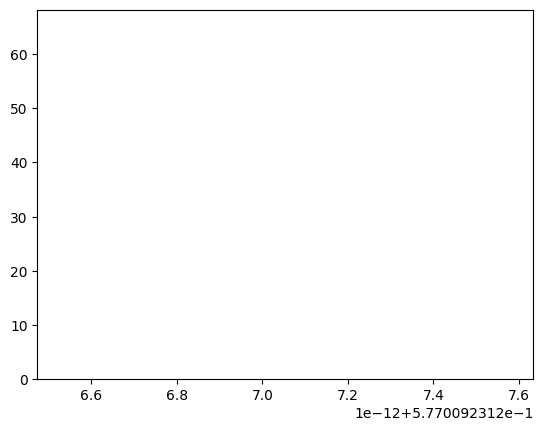

In [65]:
# Rank by growth impact of deletion on glucose growth
with model:
    model.reactions.get_by_id("EX_glc").bounds = (-5.44, 0)

    baseline_mu = model.optimize()

    growth_rates = {}
    for rxn in gap_filled_in_model["Reaction ID"]:
        with model:
            model.reactions.get_by_id(rxn).bounds = (0.,0.)
            growth_rates[rxn] = model.optimize().objective_value


fig, ax = plt.subplots()
ax.hist(growth_rates.values(), bins=20)

In [73]:
result = gap_filled_in_model.copy()
result = result.merge(pd.DataFrame([{"ID" : rxn, "mu" : mu} for rxn, mu in growth_rates.items()]),
             left_on="Reaction ID", right_on="ID")
result["Flux"] = [baseline_mu[rxn] for rxn in result["Reaction ID"]]
result["Abs Flux"] = result["Flux"].abs()
result["Fold-Change"] = result["mu"] / baseline_mu.objective_value
result.sort_values("Abs Flux", ascending=False).sort_values("Fold-Change")

,Reaction ID,Reaction name 1,Reaction name 2,In DB1?,In DB2?,Gene-reaction rule 1,Gene-reaction rule 2,Stoichiometry 1,Stoichiometry 2,Bounds 1,...,Is-Class,Has-Subclasses,Has-Instances,Issues,Recommendation,ID,mu,Flux,Abs Flux,Fold-Change
48,ORNITHINE-GLU-AMINOTRANSFERASE-RXN,NaN,Ornithine--oxo-glutarate aminotransferase,False,True,NaN,(),NaN,"{'L-ORNITHINE[c]': -1, '2-KETOGLUTARATE[c]': -...",NaN,...,False,False,False,[],Add,ORNITHINE-GLU-AMINOTRANSFERASE-RXN,0.577009,-0.494537,0.494537,1.0
8,RXN-22643,NaN,NaN,False,True,NaN,(),NaN,"{'GLUTATHIONE[c]': -1, 'FUM[c]': -1, 'CPD-2487...",NaN,...,False,False,False,['Reaction has metabolites missing from the mo...,Add,RXN-22643,0.577009,0.000000,0.000000,1.0
9,RXN-16688,NaN,NaN,True,True,(),(),"{'CPD-17968[c]': -1, 'CPD-17987[c]': 1, 'UNDEC...","{'CPD-17968[c]': -1, 'CPD-17987[c]': 1, 'UNDEC...","(0, 1000)",...,False,False,False,['Reaction has metabolites missing from the mo...,Add,RXN-16688,0.577009,0.000000,0.000000,1.0
10,RXN-9740,NaN,NaN,False,True,NaN,(),NaN,"{'CPD-7670[c]': -1, 'OXYGEN-MOLECULE[c]': -1, ...",NaN,...,False,False,False,[],Add,RXN-9740,0.577009,0.000000,0.000000,1.0
11,OXAMATE-CARBAMOYLTRANSFERASE-RXN,NaN,NaN,True,False,(),NaN,"{'OXAMATE[c]': -1, 'CARBAMOYL-P[c]': -1, 'Pi[c...",NaN,"(-1000, 0)",...,False,False,False,['Reaction has metabolites missing from the mo...,Add,OXAMATE-CARBAMOYLTRANSFERASE-RXN,0.577009,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,RXN-19320,NaN,NaN,True,False,(),NaN,"{'CPD-20855[c]': -1, 'WATER[c]': -1, 'CPD-2084...",NaN,"(0, 1000)",...,False,False,False,['Reaction has metabolites missing from the mo...,Add,RXN-19320,0.577009,0.000000,0.000000,1.0
109,RXN-16129,NaN,NaN,True,True,(),(),"{'CPD-17382[c]': -1, 'NADP[c]': -1, 'CPD-17332...","{'CPD-17382[c]': -1, 'NADP[c]': -1, 'CPD-17332...","(-1000, 0)",...,False,False,False,['Reaction has metabolites missing from the mo...,Add,RXN-16129,0.577009,0.000000,0.000000,1.0
74,RXN-21019,NaN,NaN,False,True,NaN,(),NaN,"{'CPD0-2040[c]': -1, 'GLUTATHIONE[c]': -3, 'CP...",NaN,...,False,False,False,['Reaction has metabolites missing from the mo...,Add,RXN-21019,0.577009,0.000000,0.000000,1.0
65,ORNITHINE-RACEMASE-RXN,NaN,NaN,False,True,NaN,(),NaN,"{'L-ORNITHINE[c]': -1, 'CPD-217[c]': 1}",NaN,...,False,False,False,['Reaction has metabolites missing from the mo...,Add,ORNITHINE-RACEMASE-RXN,0.577009,0.000000,0.000000,1.0


In [68]:
model.reactions.get_by_id("RXN-22729")

Reaction identifier,RXN-22729
Name,
Memory address,0x7c861b9772c0
Stoichiometry,CPD-9517[c] --> ANTHRANILATE[c] + PROTON[c] + PYRUVATE[c] (2S)-2-amino-4-deoxy-chorismate --> anthranilate + H+ + pyruvate
GPR,
Lower bound,0.0
Upper bound,1000.0


In [ ]:
model.reactions.get_by_id("RXN-16062")

KeyError: 'RXN-16062'